In [1]:
%load_ext autoreload
%autoreload 2

%aimport numpy
%aimport pandas
%aimport matplotlib.pyplot

np = numpy
pd = pandas
plt = matplotlib.pyplot
plt.rcParams['text.usetex'] = False

In [2]:
freqs = np.load("test.npy", allow_pickle=True)[()]
modes = np.load('test_obs.npy', allow_pickle=True)[()]

In [3]:
from mesa_tricks.costs import bgcost, ε_cost, low_n_cost
from mesa_tricks.utils import match_modes
from scipy.interpolate import UnivariateSpline

def seismo_model_cost(props_obs, modes, model=None):

    FAIL = [np.nan] * 7
    
    Δν_obs = props_obs['Δν']
    
    try:
        modes_model = pd.DataFrame(freqs[model])
    except:
        return FAIL
    if not len(modes_model):
        return FAIL
    
    res = match_modes(modes, modes_model)
    
    def compute(ν_obs, e_obs, ll, ν_model, n_p, E):
        if len(ν_model) == 0:
            return FAIL

        # Low n modes *should* be less affected by the surface term

        N_LOW_MODES = 5

        χ2_low_n = low_n_cost(ν_obs[ll == 0], e_obs[ll == 0], ν_model[ll == 0], n=N_LOW_MODES)

        χ2_ε = ε_cost(ν_obs, e_obs, ν_model, n_p, ll, Δν_obs, trace=True)
        z = bgcost(ν_obs, e_obs, ν_model, E, ll, l0_only=True, trace=True)

        χ2_bg, p_bg = z

        # we want dimensionless BG14 coefficients too
        νmax = float(props_obs['ν_max'])

        am1 = p_bg[0] / νmax
        a3  = p_bg[1] * νmax**3

        bm1 = p_bg[0] / νmax**2
        b3  = p_bg[1] * νmax**2

        return (χ2_low_n, χ2_bg, χ2_ε, am1, a3, bm1, b3)

    return compute(**res)

/home/jjo25/.local/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py:1647: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


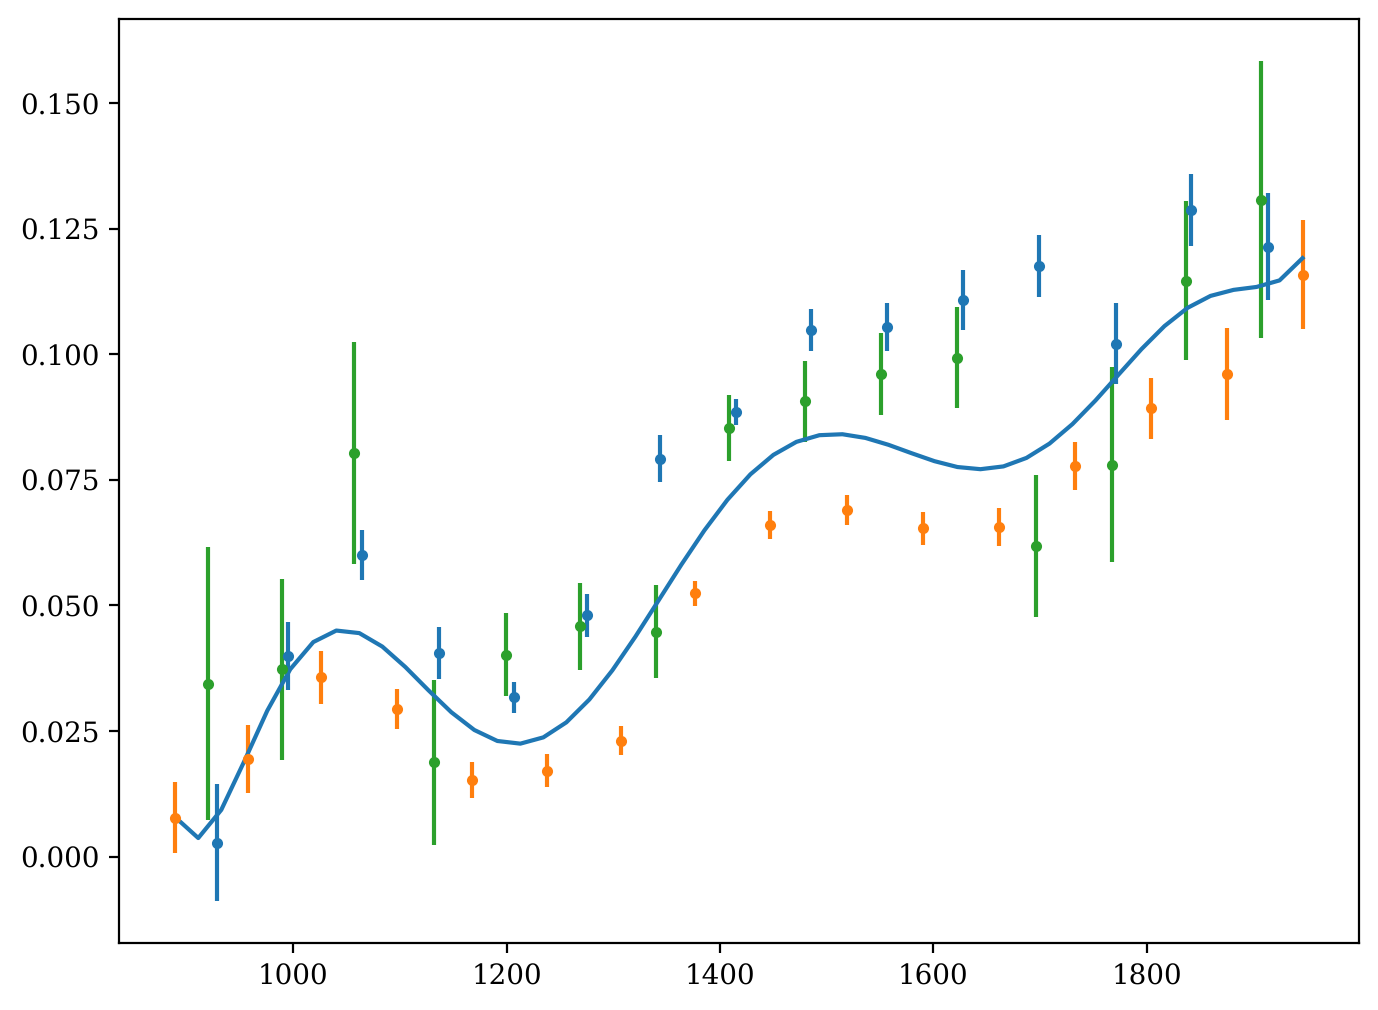

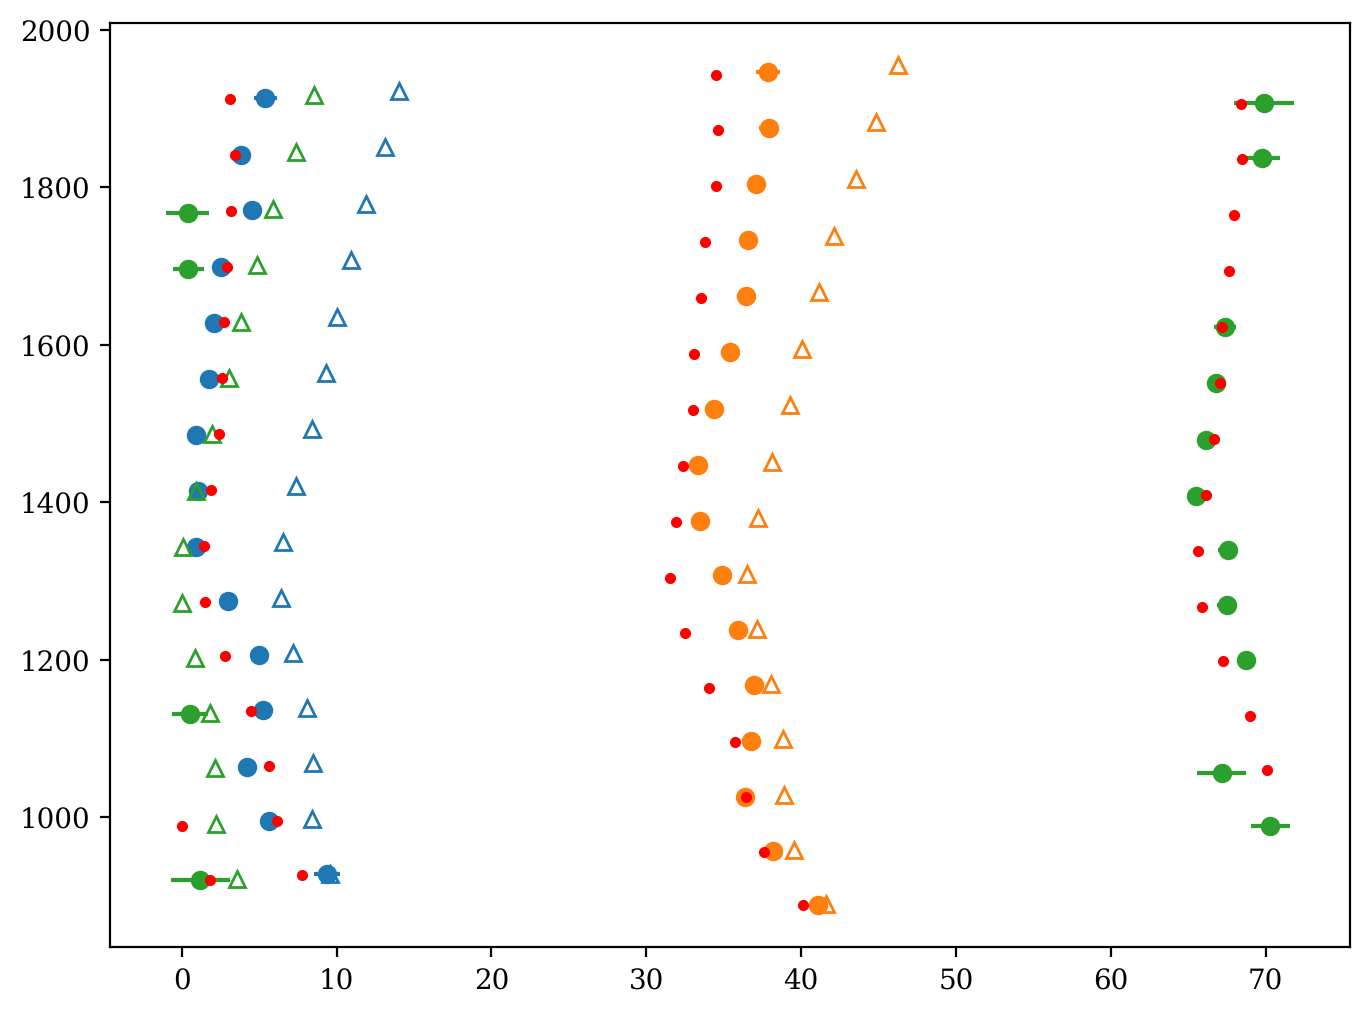

(0.8540506950184006,
 33.297516526995906,
 11.410247434648626,
 -3.5040978492354744e-08,
 4.905150957571596e-10,
 -2.4910057931580824e-11,
 3.486991510323165e-13)

In [4]:
plt.close('all')
seismo_model_cost({'Δν': 70.369, 'ν_max': 1406.7}, modes, model='2885_72')